## Imports

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy

from gwdetchar.io.datafind import get_data
from gwpy.timeseries import TimeSeries
from gwpy.timeseries import TimeSeriesDict
from scipy.interpolate import UnivariateSpline, interp1d

## Outlier removal functions

In [62]:
## Original outlier removal methods (z-score and n-percentile)

def find_outliers(ts, N=5, method='s'):
    """Find outliers within a `TimeSeries`

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        data to find outliers within

    N : `float`, optional
        if `method='s'`: number of standard deviations to consider an outlier
        if `method='pf'`: percentile range limit to consider an outlier
        default for both methods: 5
    method : `str`, optional
        outlier identification method to be used, must be `'s'` (standard
        deviation method) or `'pf'` (percentil range method)
        default: `'s'`

    Returns
    -------
    out : `ndarray`
        array indices of the input where outliers occur
    """
    if method == 'pf':
        ts = ts.value  # strip out Quantity extras
        quantile = numpy.quantile(ts, N)
        outliers = []
        for i, x in enumerate(ts):
            if x < quantile:
                outliers.append(i)
        return numpy.array(outliers)
    else:
        ts = ts.value  # strip out Quantity extras
        return numpy.nonzero(abs(ts - ts.mean()) > N*ts.std())[0]


def remove_outliers(ts, N=5, method='s'):
    """Find and remove outliers within a `TimeSeries`

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        data to find outliers within

    N : `float`, optional
        if `method='s'`: number of standard deviations to consider an outlier
        if `method='pf'`: percentile range limit to consider an outlier
        default for both methods: 5
    method : `str`, optional
        outlier identification method to be used, must be `'s'` (standard
        deviation method) or `'pf'` (percentil range method)
        default: `'s'`

    Notes
    -----
    This action is done in-place, with no `return` statement.
    """
    if method == 'pf':
        outliers = find_outliers(ts, N=N, method='pf')
        # print("There are %d outliers in this data" % len(outliers))
        # unit = ts.unit
        # mask = numpy.ones(ts.size, dtype=bool)
        # mask[outliers] = False
        # spline = UnivariateSpline(ts.times.value[mask],
        #                           ts.value[mask], s=0, k=3)
        # ts[outliers] = spline(ts.times.value[outliers]) * unit
        # ts = ts[1:-1]
        # print('Outlier removal complete')
        remove_by_idx(ts, outliers)
    else:
        outliers = find_outliers(ts, N=N, method='s')
        c = 1
        while outliers.any():
            print("-- Pass %d: removing %d outliers in %s" % (c, outliers.size, ts.name))
            cache = outliers
            remove_by_idx(ts, outliers)
            #unit = ts.unit
            #mask = numpy.ones(ts.size, dtype=bool)
            #mask[outliers] = False
            #spline = UnivariateSpline(ts.times.value[mask], ts.value[mask],
            #                          s=0, k=3)
            #ts[outliers] = spline(ts.times.value[outliers]) * unit
            #outliers = find_outliers(ts, N=N, method='s')
            print("   Completed %d removal passes" % c)
            if numpy.array_equal(outliers, cache):
                print("   Outliers did not change, breaking recursion")
                break
            print("   %d outliers remain" % len(outliers))
            c += 1

In [98]:
## New outlier removal functions (LOF and TOF)

import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from uniqed.runners.tof_run import detect_outlier

def find_lof_outliers(ts, crit_lof=1.5, n_neighbors=20):
    """Find outliers within a `Timeseries` using the LOF metric

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        data to find outliers within

    crit_lof: `float`, optional
        minimum LOF to consider a point an outlier
        default: 1.5
    
    n_neighbors: `int`, optional
        number of neighboring data points to consider when calculating LOF
        default: 20
    
    Returns
    -------
    out : `ndarray`
        array indices of the input where outliers occur
    """
    parser = get_lof_parser(ts, n_neighbors)
    is_outlier = parser.negative_outlier_factor_ < -crit_lof
    return numpy.arange(0, is_outlier.size)[is_outlier]


def find_lof_quantile(ts, q=0.05, n_neighbors=20):
    """Find the lowest q-quantile of data sorted by LOF

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        data to find outliers within

    q: `float` between 0 and 1, optional
        q-quantile to remove
        default: 0.05
    
    n_neighbors: `int`, optional
        number of neighboring data points to consider when calculating LOF
        default: 20
    
    Returns
    -------
    out : `ndarray`
        array indices of the input where outliers occur
    """
    parser = get_lof_parser(ts, n_neighbors)
    indices = list(range(parser.negative_outlier_factor_.size))
    indices.sort(reverse=False, key=lambda i: parser.negative_outlier_factor_[i])
    quantile = int(q*parser.negative_outlier_factor_.size)
    return numpy.array(indices)[:quantile]

def get_lof_parser(ts, n_neighbors=20):
    """Generate a LocalOutlierFactor object fitted to data

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        data to fit
        
    n_neighbors: `int`, optional
        number of neighboring data points to consider when calculating LOF
        default: 20
    
    Returns
    -------
    out : `LocalOutlierFactor`
        sklearn LocalOutlierFactor fitted to input time series
    """
    data = ts.value
    # transform to 2D scatter
    vrange = 8*(numpy.max(data) - numpy.min(data))
    xdata, xspacing = numpy.linspace(0, vrange, num=data.size, retstep=True)
    print('LOF x-spacing set to %f' % xspacing)
    data = numpy.stack((xdata, data), axis=-1)
    parser = LocalOutlierFactor(p=1, n_neighbors=n_neighbors)
    parser.fit_predict(data)
    return parser


def find_tof_outliers(ts, cutoff_n=5):
    """Find outliers within a `Timeseries` using the TOF metric

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        data to find outliers within

    cutoff_n: `int`, optional
        longest acceptable length of an anomalous event (# data points)
        default: 5
    
    Returns
    -------
    out : `ndarray`
        array indices of the input where outliers occur
    """
    time_series = pd.DataFrame(ts.value)
    res_df = detect_outlier(time_series, cutoff_n=cutoff_n)
    tofs = res_df['TOF_score'].to_numpy()
    return numpy.arange(tofs.size)[tofs <= 0]


def remove_by_idx(ts, indices, kind='linear'):
    """Remove elements within a `TimeSeries` by index

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        time series

    indices: `np.array(int)`
        indices at which outliers occur

    Notes
    -----
    This action is done to ts in-place, with no `return` statement.
    """
    print("Removing %d elements from time series and replacing via %s interpolation" % (len(indices), kind))
    mask = numpy.ones(ts.size, dtype=bool)
    mask[indices] = False
    x = numpy.arange(0, ts.size)[mask]
    y = ts.value[mask]
    # If endpoints are clipped by outlier removal, fill them back in with constant interpolation
    if 0 in indices:
        print("Left endpoint was clipped, filling back with constant interpolation")
        x = numpy.insert(x, 0, 0)
        y = numpy.insert(y, 0, y[0])
    if ts.size-1 in indices:
        print("Right endpoint was clipped, filling back with constant interpolation")
        x = numpy.append(x, ts.size)
        y = numpy.append(y, y[-1])
    interpolant = interp1d(x, y, kind=kind)
    ts[indices] = interpolant(indices) * ts.unit


## Data fetching

/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/io/nds2.py:122: UserWarning: Requested at least one minute trend, but start and stop GPS times are not multiples of 60. Times will be expanded outwards to compensate
  warnings.warn("Requested at least one minute trend, but "


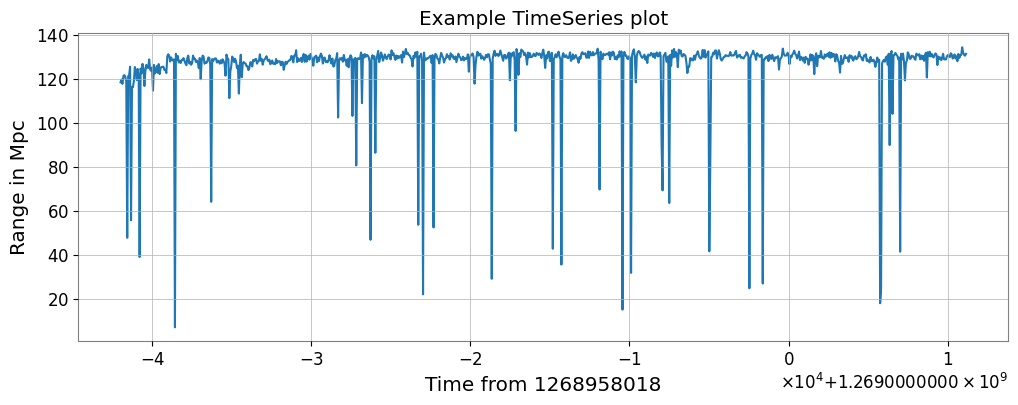

In [60]:
# For a single channel
channel = "L1:DMT-SNSW_EFFECTIVE_RANGE_MPC.mean"
gps_start = 1268958018
gps_end = 1269011267

ex_ts = TimeSeries.get(channel, gps_start, gps_end)
fig, ax = plt.subplots(figsize=[12,4])
ax.plot(ex_ts)
ax.set_title("Example TimeSeries plot")
ax.set_xlabel("Time from " + str(gps_start))
ax.set_ylabel("Range in Mpc")
fig.show()

## Outlier removal method comparisons

/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/io/nds2.py:122: UserWarning: Requested at least one minute trend, but start and stop GPS times are not multiples of 60. Times will be expanded outwards to compensate
  warnings.warn("Requested at least one minute trend, but "


The z-score method found outliers at: [  7  11  20  57  95 247 262 267 312 317 328 389 453 462 502 526
 535 568 575 617 618 659 673 796 797 817]
The percentile method found outliers at: [  0   2   6   7  11  12  13  14  20  25  34  57  95 114 124 228
 243 247 253 262 267 312 317 328 371 389 414 453 462 502 526 535
 540 567 568 575 617 618 659 673 796 797 806 809 817]
-- Pass 1: removing 26 outliers in L1:DMT-SNSW_EFFECTIVE_RANGE_MPC.mean
Removing 26 elements from time series and replacing via linear interpolation
   Completed 1 removal passes
   Outliers did not change, breaking recursion
Removing 45 elements from time series and replacing via linear interpolation
Left endpoint was clipped, filling back with constant interpolation


/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/io/nds2.py:122: UserWarning: Requested at least one minute trend, but start and stop GPS times are not multiples of 60. Times will be expanded outwards to compensate
  warnings.warn("Requested at least one minute trend, but "


Removing 57 elements from time series and replacing via linear interpolation
Left endpoint was clipped, filling back with constant interpolation
Right endpoint was clipped, filling back with constant interpolation


/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/io/nds2.py:122: UserWarning: Requested at least one minute trend, but start and stop GPS times are not multiples of 60. Times will be expanded outwards to compensate
  warnings.warn("Requested at least one minute trend, but "


Removing 44 elements from time series and replacing via linear interpolation
Left endpoint was clipped, filling back with constant interpolation
Right endpoint was clipped, filling back with constant interpolation


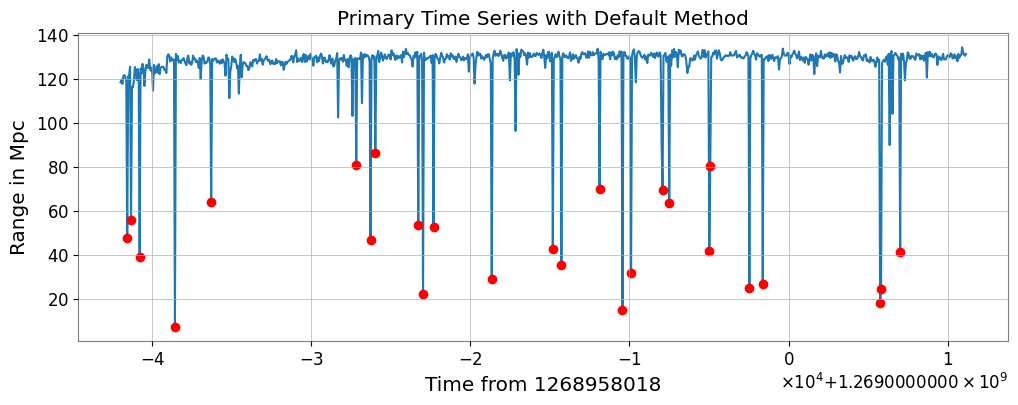

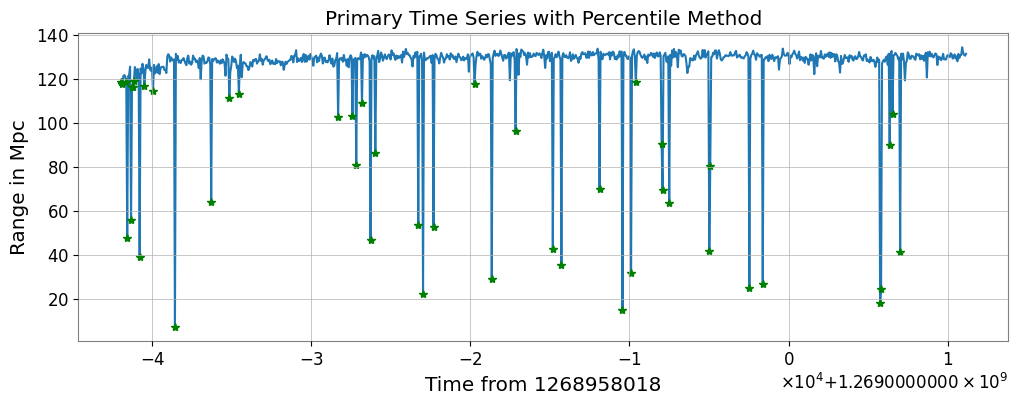

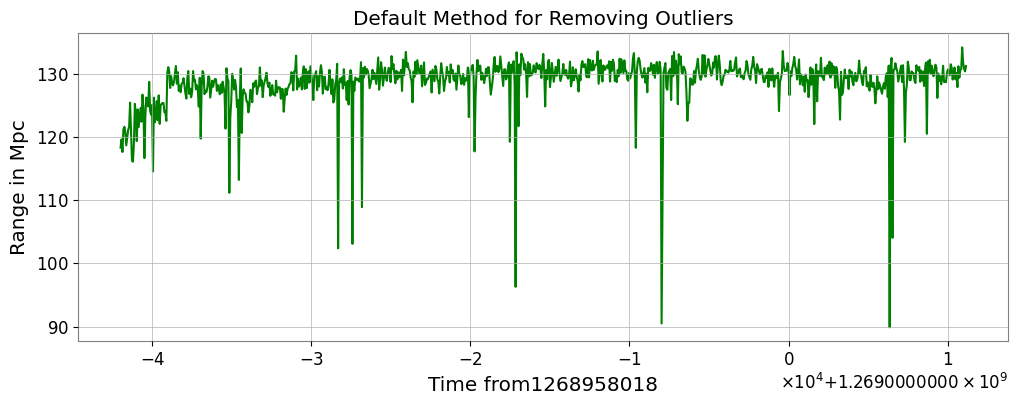

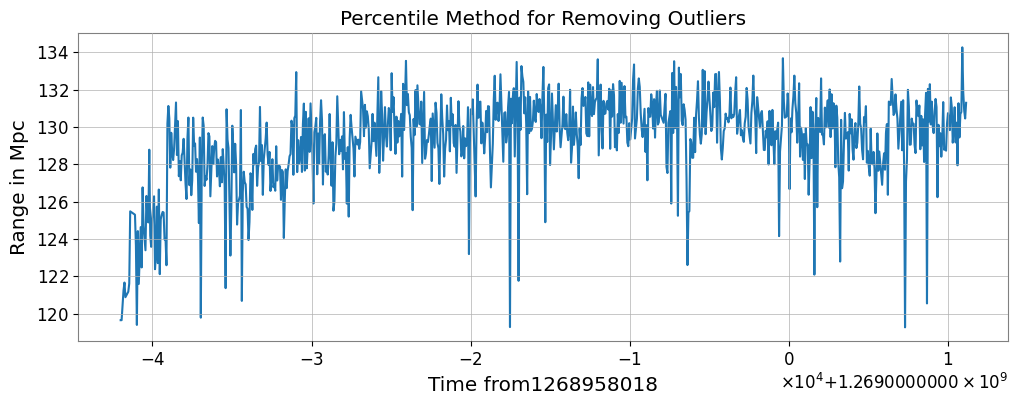

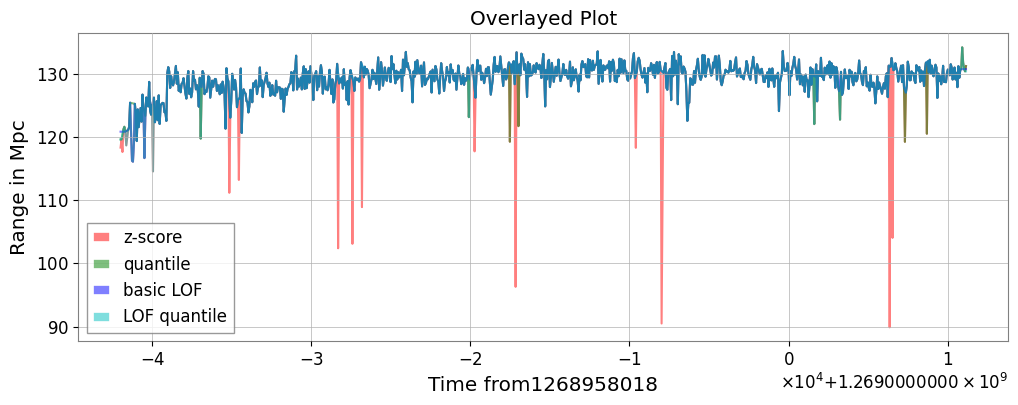

In [70]:
# Pulling data from channels to test the spline acting on outlier data in the range
channel = "L1:DMT-SNSW_EFFECTIVE_RANGE_MPC.mean"

# start and end represent the begining and end times (gps) that data is pulled from
# use tconvert(gps_time) to find the date

start, end = (1268958018, 1269011267)
#start, end = (1264982418, 1264982418+53249) # Feb 6, 2020
#start, end = (1264982418, 1264982418+53249) # Feb 6, 2020
#start, end = (1264982418, 1264982418+53249) # Feb 6, 2020
#start, end = (1264982418, 1264982418+53249) # Feb 6, 2020

# Creating TimeSeries to run the outlier removal on
ts1 = TimeSeries.get(channel, start, end)
ts2 = TimeSeries.get(channel, start, end)

# Comparing outliers found by both methods
old = find_outliers(ts1, N=2.5, method='s')
new = find_outliers(ts2, N=.05, method='pf')
print("The z-score method found outliers at:", old)
print("The percentile method found outliers at:", new)

# This will plot the unaltered data with the outliers found by the default method
# This method is supposed to run iteratively, more work would need to be done to see the progression of identified outliers
fig1, ax1 = plt.subplots(figsize=[12,4])
ax1.plot(ts1)
ax1.plot(ts1.times.value[old], ts1.value[old], 'ro')
ax1.set_title("Primary Time Series with Default Method")
ax1.set_xlabel("Time from " + str(start))
ax1.set_ylabel("Range in Mpc")
fig1.show()
#plt.savefig('./outlier_plots/Mar23_original.png')

#This will plot the unaltered data with the outliers found by the percentile method in green stars
fig2, ax2 = plt.subplots(figsize=[12,4])
ax2.plot(ts2)
ax2.plot(ts2.times.value[new], ts2.value[new], 'g*')
ax2.set_title("Primary Time Series with Percentile Method")
ax2.set_xlabel("Time from " + str(start))
ax2.set_ylabel("Range in Mpc")
fig2.show()
#plt.savefig('./outlier_plots/Mar23_percentile_outlier_find.png')

#The default outlier removal now acts on ts1
remove_outliers(ts1, N=2.5)
fig3, ax3 = plt.subplots(figsize=[12,4])
#ax3.plot(ts2, color='blue')
ax3.plot(ts1, color='green')
ax3.set_title("Default Method for Removing Outliers")
ax3.set_xlabel("Time from" + str(start))
ax3.set_ylabel("Range in Mpc")
fig3.show()
#plt.savefig('./outlier_plots/Mar23_original_removal.png')

#The percentile outlier removal now acts on ts2
remove_outliers(ts2, N=.05, method='pf')
fig4, ax4 = plt.subplots(figsize=[12,4])
ax4.plot(ts2)
ax4.set_title("Percentile Method for Removing Outliers")
ax4.set_xlabel("Time from" + str(start))
ax4.set_ylabel("Range in Mpc")
fig4.show()
#plt.savefig('./outlier_plots/Mar23_percentile_removal.png')

# Basic LOF method
min_lof = 1.1
n_neighbors = 20
ts4 = TimeSeries.get(channel, start, end)
outliers = find_lof_outliers(ts4, min_lof, n_neighbors)
remove_by_idx(ts4, outliers)

# LOF quantile method
q = 0.05
n_neighbors = 20
ts3 = TimeSeries.get(channel, start, end)
outliers = find_lof_quantile(ts3, q, n_neighbors)
remove_by_idx(ts3, outliers)

#This plot overlays the TimeSeries for a direct comparison
fig5, ax5 = plt.subplots(figsize=[12,4])
ax5.plot(ts1, 'r', label='z-score', alpha=0.5)
ax5.plot(ts2, 'g', label='quantile', alpha=0.5)
ax5.plot(ts4, 'b', label='basic LOF', alpha=0.5)
ax5.plot(ts3, 'c', label='LOF quantile', alpha=0.5)
ax5.set_title("Overlayed Plot")
ax5.set_xlabel("Time from" + str(start))
ax5.set_ylabel("Range in Mpc")
ax5.legend()
fig5.show()
#plt.savefig('./outlier_plots/Mar23_percentile_removal.png')

### LOF and TOF

/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/io/nds2.py:122: UserWarning: Requested at least one minute trend, but start and stop GPS times are not multiples of 60. Times will be expanded outwards to compensate
  warnings.warn("Requested at least one minute trend, but "


LOF x-spacing set to 1.148068
Removing 37 elements from time series and replacing via linear interpolation


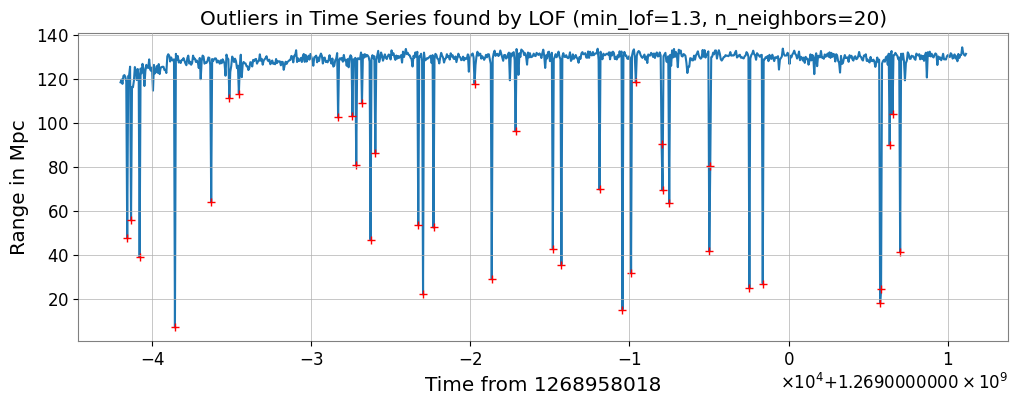

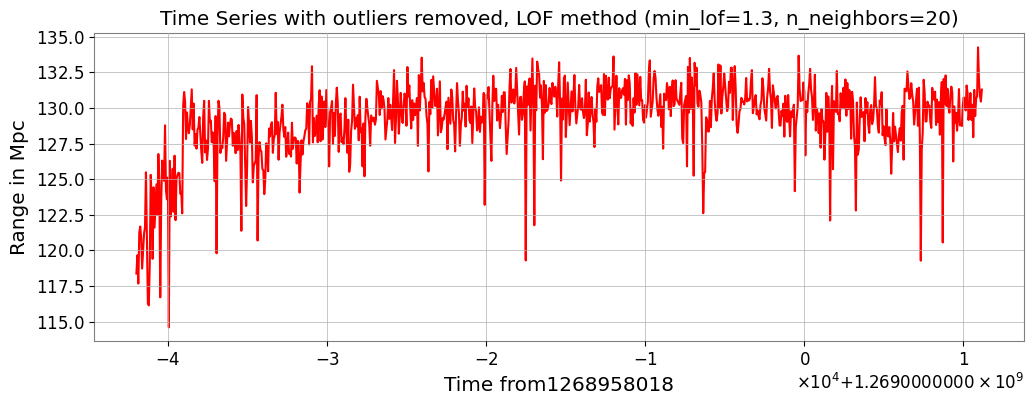

In [101]:
# LOF method

min_lof = 1.3
n_neighbors = 20
ts = TimeSeries.get(channel, start, end)
outliers = find_lof_outliers(ts, min_lof, n_neighbors)
fig1, ax1 = plt.subplots(figsize=[12,4])
ax1.plot(ts)
ax1.plot(ts.times.value[outliers], ts.value[outliers], 'r+')
ax1.set_title("Outliers in Time Series found by LOF (min_lof=%.1f, n_neighbors=%d)" % (min_lof, n_neighbors))
ax1.set_xlabel("Time from " + str(start))
ax1.set_ylabel("Range in Mpc")
fig1.show()

remove_by_idx(ts, outliers)
fig2, ax2 = plt.subplots(figsize=[12,4])
ax2.plot(ts, color='red')
ax2.set_title("Time Series with outliers removed, LOF method (min_lof=%.1f, n_neighbors=%d)" % (min_lof, n_neighbors))
ax2.set_xlabel("Time from" + str(start))
ax2.set_ylabel("Range in Mpc")
fig2.show()

LOF x-spacing set to 1.435085
Removing 44 elements from time series and replacing via linear interpolation
Left endpoint was clipped, filling back with constant interpolation
Right endpoint was clipped, filling back with constant interpolation


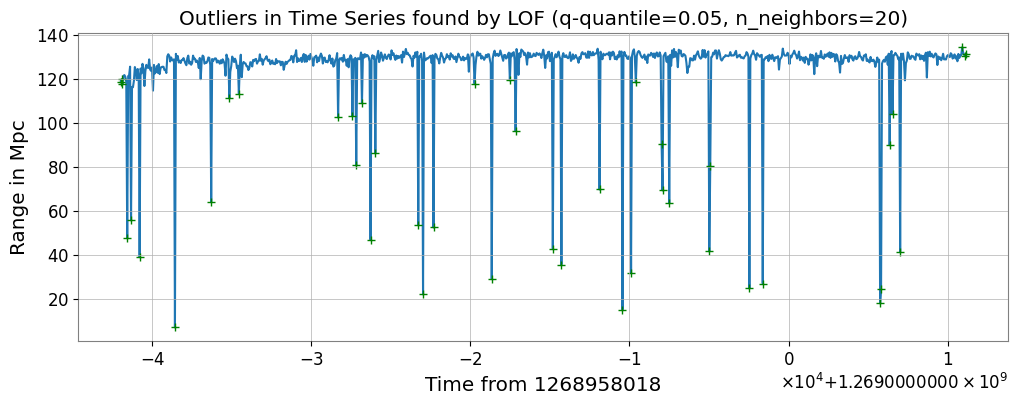

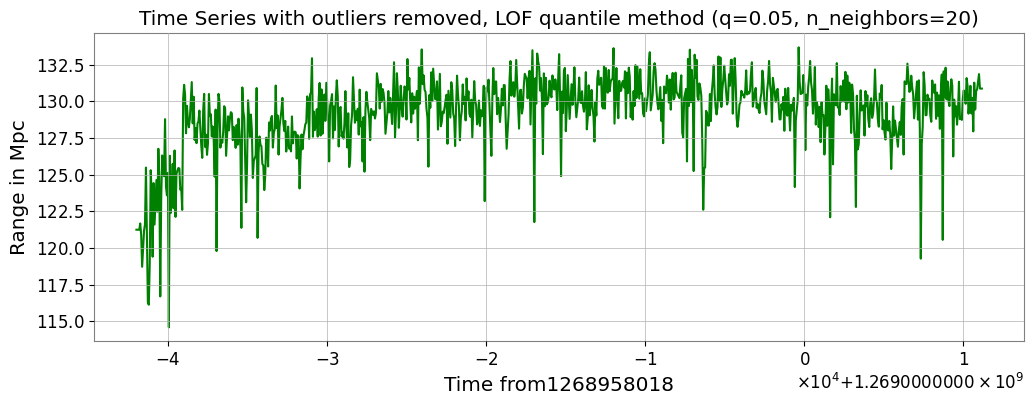

In [92]:
# LOF quantile method

q = 0.05
n_neighbors = 20
ts = TimeSeries.get(channel, start, end)
outliers = find_lof_quantile(ts, q, n_neighbors)
fig1, ax1 = plt.subplots(figsize=[12,4])
ax1.plot(ts)
ax1.plot(ts.times.value[outliers], ts.value[outliers], 'g+')
ax1.set_title("Outliers in Time Series found by LOF (q-quantile=%.2f, n_neighbors=%d)" % (q, n_neighbors))
ax1.set_xlabel("Time from " + str(start))
ax1.set_ylabel("Range in Mpc")
fig1.show()

remove_by_idx(ts, outliers)
fig2, ax2 = plt.subplots(figsize=[12,4])
ax2.plot(ts, color='green')
ax2.set_title("Time Series with outliers removed, LOF quantile method (q=%.2f, n_neighbors=%d)" % (q, n_neighbors))
ax2.set_xlabel("Time from" + str(start))
ax2.set_ylabel("Range in Mpc")
fig2.show()

/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/io/nds2.py:122: UserWarning: Requested at least one minute trend, but start and stop GPS times are not multiples of 60. Times will be expanded outwards to compensate
  warnings.warn("Requested at least one minute trend, but "


Removing 0 elements from time series and replacing via linear interpolation


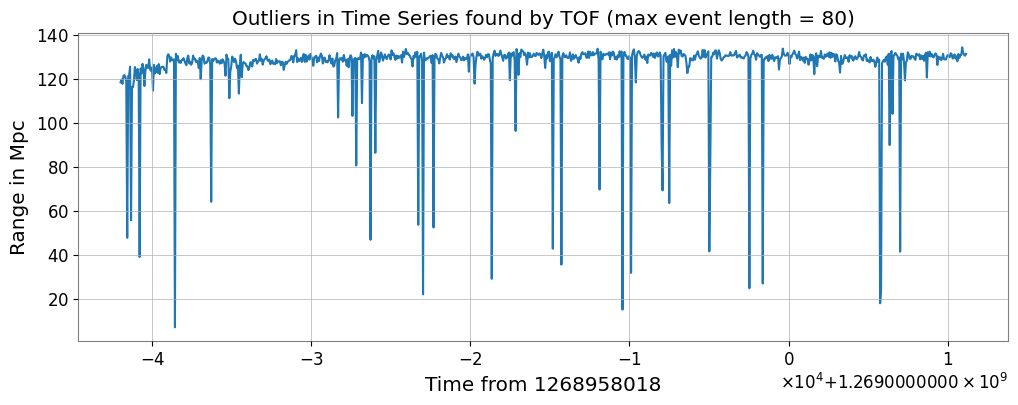

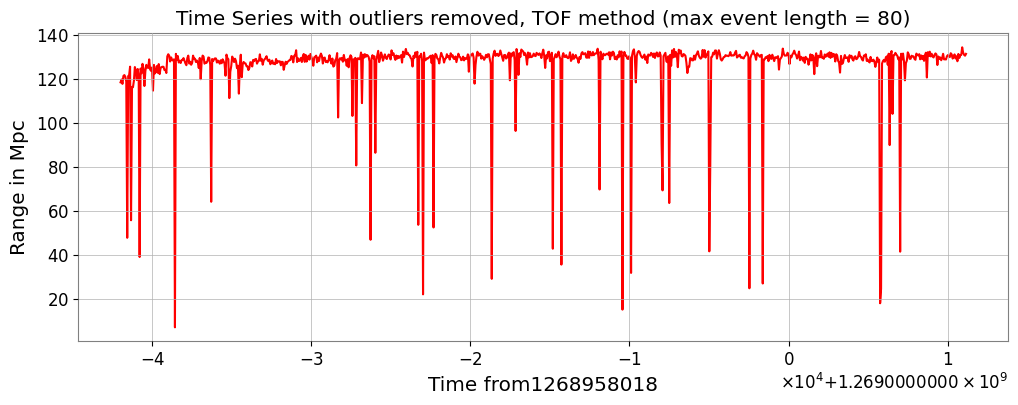

In [66]:
# TOF method

cutoff_n = 80
ts = TimeSeries.get(channel, start, end)
outliers = find_tof_outliers(ts, cutoff_n)
fig1, ax1 = plt.subplots(figsize=[12,4])
ax1.plot(ts)
ax1.plot(ts.times.value[outliers], ts.value[outliers], 'r*')
ax1.set_title("Outliers in Time Series found by TOF (max event length = %d)" % cutoff_n)
ax1.set_xlabel("Time from " + str(start))
ax1.set_ylabel("Range in Mpc")
fig1.show()

remove_by_idx(ts, outliers)
fig2, ax2 = plt.subplots(figsize=[12,4])
ax2.plot(ts, color='red')
ax2.set_title("Time Series with outliers removed, TOF method (max event length = %d)" % cutoff_n)
ax2.set_xlabel("Time from" + str(start))
ax2.set_ylabel("Range in Mpc")
fig2.show()